In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
n_data = 500
n_var = 2

data_inp1 = torch.zeros((n_data, n_var))
data_inp1[:, 0] = 0.4
data_inp1[:, 1] = torch.rand((n_data,1)).reshape(-1,)

data_inp2 = torch.zeros((n_data, n_var))
data_inp2[:, 0] = 0.7
data_inp2[:, 1] = data_inp1[:, 1]

data_inp3 = torch.zeros((n_data, n_var))
data_inp3[:, 0] = 1
data_inp3[:, 1] = data_inp1[:, 1]

In [5]:
u_data1 = exact_solution_u(data_inp1[:, 0], data_inp1[:, 1])
u_data1 = u_data1.reshape(-1,1)

u_data2 = exact_solution_u(data_inp2[:, 0], data_inp2[:, 1])
u_data2 = u_data2.reshape(-1,1)

u_data3 = exact_solution_u(data_inp3[:, 0], data_inp3[:, 1])
u_data3 = u_data3.reshape(-1,1)

In [6]:
sigma=0.0
u_data1 = u_data1*(1 + sigma*torch.randn(500,1))
u_data2 = u_data2*(1 + sigma*torch.randn(500,1))
u_data3 = u_data3*(1 + sigma*torch.randn(500,1))

In [7]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [8]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = torch.rand((initial_pts,1)) + 0.2 # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) + 0.2 # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = torch.ones((right_boundary_pts, 1)) + 0.2 # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = torch.rand((residual_pts, 1)) + 0.2
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=200, shuffle=False)

In [9]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [10]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1]+1, n_hidden_layers=4, neurons=20)


In [11]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [12]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [13]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                func = w_hat[:, 2].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
                
                output_data_pred1_ = model(data_inp1)
                u_data_pred1_ = output_data_pred1_[:, 0]
                
                output_data_pred2_ = model(data_inp2)
                u_data_pred2_ = output_data_pred2_[:, 0]
                
                output_data_pred3_ = model(data_inp3)
                u_data_pred3_ = output_data_pred3_[:, 0]
             
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + 0.1*torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ 0.1*torch.mean((2*p_t.reshape(-1, )  + u_x.reshape(-1, ) - func.reshape(-1, ))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                data = torch.mean((u_data_pred1_.reshape(-1, ) - u_data1.reshape(-1, ))**p) + torch.mean((u_data_pred2_.reshape(-1, ) - u_data2.reshape(-1, ))**p) + torch.mean((u_data_pred3_.reshape(-1, ) - u_data3.reshape(-1, ))**p)
                loss = loss1 + loss2 + data
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
                #func = torch.cos(interior[:, 0])*torch.cos(interior[:, 1])
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [14]:
n_epochs = 2500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  5.0566511154174805
################################  1  ################################
Loss:  4.910475730895996
################################  2  ################################
Loss:  4.2274041175842285
################################  3  ################################
Loss:  3.530301570892334
################################  4  ################################
Loss:  2.902789831161499
################################  5  ################################
Loss:  2.3572769165039062
################################  6  ################################
Loss:  1.9579886198043823
################################  7  ################################
Loss:  1.6513103246688843
################################  8  ################################
Loss:  1.397615909576416
################################  9  ################################
Loss:  1.1871321201324463
################################  10  ######

Loss:  0.0037639886140823364
################################  90  ################################
Loss:  0.003688393160700798
################################  91  ################################
Loss:  0.0036109972279518843
################################  92  ################################
Loss:  0.0035351524129509926
################################  93  ################################
Loss:  0.003461341140791774
################################  94  ################################
Loss:  0.0033920491114258766
################################  95  ################################
Loss:  0.003324538469314575
################################  96  ################################
Loss:  0.003258008975535631
################################  97  ################################
Loss:  0.0031939526088535786
################################  98  ################################
Loss:  0.0031299442052841187
################################  99  ################################
Loss

Loss:  0.0006020491127856076
################################  178  ################################
Loss:  0.0005928257596679032
################################  179  ################################
Loss:  0.0005839324439875782
################################  180  ################################
Loss:  0.0005750976852141321
################################  181  ################################
Loss:  0.0005665466887876391
################################  182  ################################
Loss:  0.000557902327273041
################################  183  ################################
Loss:  0.00054923229617998
################################  184  ################################
Loss:  0.0005409631412476301
################################  185  ################################
Loss:  0.0005328202969394624
################################  186  ################################
Loss:  0.0005256531876511872
################################  187  ##########################

Loss:  0.00019548993441276252
################################  264  ################################
Loss:  0.00019376829732209444
################################  265  ################################
Loss:  0.0001920913637150079
################################  266  ################################
Loss:  0.0001905069366330281
################################  267  ################################
Loss:  0.00018896438996307552
################################  268  ################################
Loss:  0.00018748718139249831
################################  269  ################################
Loss:  0.00018599106988403946
################################  270  ################################
Loss:  0.00018453877419233322
################################  271  ################################
Loss:  0.00018319104856345803
################################  272  ################################
Loss:  0.00018196608289144933
################################  273  ###############

Loss:  0.00011117053509224206
################################  351  ################################
Loss:  0.00010993269097525626
################################  352  ################################
Loss:  0.00010873316205106676
################################  353  ################################
Loss:  0.0001075766485882923
################################  354  ################################
Loss:  0.0001065039832610637
################################  355  ################################
Loss:  0.00010548215504968539
################################  356  ################################
Loss:  0.00010455914889462292
################################  357  ################################
Loss:  0.00010360373562434688
################################  358  ################################
Loss:  0.0001025231831590645
################################  359  ################################
Loss:  0.00010150306479772553
################################  360  ################

Loss:  5.2539431635523215e-05
################################  436  ################################
Loss:  5.221231549512595e-05
################################  437  ################################
Loss:  5.189968942431733e-05
################################  438  ################################
Loss:  5.1550381613196805e-05
################################  439  ################################
Loss:  5.1196653657825664e-05
################################  440  ################################
Loss:  5.084932126919739e-05
################################  441  ################################
Loss:  5.0527145504020154e-05
################################  442  ################################
Loss:  5.020248136133887e-05
################################  443  ################################
Loss:  4.981527308700606e-05
################################  444  ################################
Loss:  4.950302536599338e-05
################################  445  ###################

Loss:  3.4085489460267127e-05
################################  526  ################################
Loss:  3.400504283490591e-05
################################  527  ################################
Loss:  3.392561120563187e-05
################################  528  ################################
Loss:  3.384778028703295e-05
################################  529  ################################
Loss:  3.3772266760934144e-05
################################  530  ################################
Loss:  3.3697011531330645e-05
################################  531  ################################
Loss:  3.3625336072873324e-05
################################  532  ################################
Loss:  3.3556698326719925e-05
################################  533  ################################
Loss:  3.3489861380076036e-05
################################  534  ################################
Loss:  3.3426629670429975e-05
################################  535  ################

Loss:  2.2175370759214275e-05
################################  613  ################################
Loss:  2.2030737454770133e-05
################################  614  ################################
Loss:  2.189059705415275e-05
################################  615  ################################
Loss:  2.1756832211394794e-05
################################  616  ################################
Loss:  2.162122109439224e-05
################################  617  ################################
Loss:  2.1485269826371223e-05
################################  618  ################################
Loss:  2.1358966478146613e-05
################################  619  ################################
Loss:  2.1219075279077515e-05
################################  620  ################################
Loss:  2.1081461454741657e-05
################################  621  ################################
Loss:  2.096466596412938e-05
################################  622  ################

Loss:  1.3611072063213214e-05
################################  697  ################################
Loss:  1.3497251529770438e-05
################################  698  ################################
Loss:  1.3389780178840738e-05
################################  699  ################################
Loss:  1.3297874829731882e-05
################################  700  ################################
Loss:  1.321683703281451e-05
################################  701  ################################
Loss:  1.3145448065188248e-05
################################  702  ################################
Loss:  1.308292576140957e-05
################################  703  ################################
Loss:  1.302913369727321e-05
################################  704  ################################
Loss:  1.2982423868379556e-05
################################  705  ################################
Loss:  1.2941740351379849e-05
################################  706  ################

Loss:  1.074056672223378e-05
################################  783  ################################
Loss:  1.0719953024818096e-05
################################  784  ################################
Loss:  1.0697847756091505e-05
################################  785  ################################
Loss:  1.067840821633581e-05
################################  786  ################################
Loss:  1.0660864973033313e-05
################################  787  ################################
Loss:  1.0640987056831364e-05
################################  788  ################################
Loss:  1.0623431990097743e-05
################################  789  ################################
Loss:  1.0604561794025358e-05
################################  790  ################################
Loss:  1.0589087651169393e-05
################################  791  ################################
Loss:  1.0572433893685229e-05
################################  792  ###############

Loss:  8.351292308361735e-06
################################  868  ################################
Loss:  8.323991096403915e-06
################################  869  ################################
Loss:  8.298462489619851e-06
################################  870  ################################
Loss:  8.271081242128275e-06
################################  871  ################################
Loss:  8.239450835390016e-06
################################  872  ################################
Loss:  8.208739018300548e-06
################################  873  ################################
Loss:  8.177229574357625e-06
################################  874  ################################
Loss:  8.141796570271254e-06
################################  875  ################################
Loss:  8.111730494420044e-06
################################  876  ################################
Loss:  8.07925061963033e-06
################################  877  ########################

Loss:  6.732283054589061e-06
################################  956  ################################
Loss:  6.7199371187598445e-06
################################  957  ################################
Loss:  6.706828571623191e-06
################################  958  ################################
Loss:  6.693352588627022e-06
################################  959  ################################
Loss:  6.680813839921029e-06
################################  960  ################################
Loss:  6.66848700348055e-06
################################  961  ################################
Loss:  6.6564848566486035e-06
################################  962  ################################
Loss:  6.645816938544158e-06
################################  963  ################################
Loss:  6.635535100940615e-06
################################  964  ################################
Loss:  6.626198228332214e-06
################################  965  ######################

Loss:  5.29431963514071e-06
################################  1046  ################################
Loss:  5.290355147735681e-06
################################  1047  ################################
Loss:  5.286643045110395e-06
################################  1048  ################################
Loss:  5.283140126266517e-06
################################  1049  ################################
Loss:  5.279719516693149e-06
################################  1050  ################################
Loss:  5.276966476230882e-06
################################  1051  ################################
Loss:  5.2744658205483574e-06
################################  1052  ################################
Loss:  5.2719383347721305e-06
################################  1053  ################################
Loss:  5.26921394339297e-06
################################  1054  ################################
Loss:  5.2667110139736906e-06
################################  1055  ############

Loss:  4.862471996602835e-06
################################  1135  ################################
Loss:  4.8604638323013205e-06
################################  1136  ################################
Loss:  4.858562533627264e-06
################################  1137  ################################
Loss:  4.8568622332823e-06
################################  1138  ################################
Loss:  4.855111001234036e-06
################################  1139  ################################
Loss:  4.853705831919797e-06
################################  1140  ################################
Loss:  4.851985977438744e-06
################################  1141  ################################
Loss:  4.850211098528234e-06
################################  1142  ################################
Loss:  4.848302069149213e-06
################################  1143  ################################
Loss:  4.84682323076413e-06
################################  1144  ###############

Loss:  4.349821210780647e-06
################################  1219  ################################
Loss:  4.333495780883823e-06
################################  1220  ################################
Loss:  4.316767444834113e-06
################################  1221  ################################
Loss:  4.2994352043024264e-06
################################  1222  ################################
Loss:  4.282186637283303e-06
################################  1223  ################################
Loss:  4.264686140231788e-06
################################  1224  ################################
Loss:  4.247755896358285e-06
################################  1225  ################################
Loss:  4.230754711898044e-06
################################  1226  ################################
Loss:  4.21440881837043e-06
################################  1227  ################################
Loss:  4.1981884351116605e-06
################################  1228  ############

Loss:  3.492311634545331e-06
################################  1307  ################################
Loss:  3.4889626476797275e-06
################################  1308  ################################
Loss:  3.486102968963678e-06
################################  1309  ################################
Loss:  3.4832287383324e-06
################################  1310  ################################
Loss:  3.480507757558371e-06
################################  1311  ################################
Loss:  3.4777101518557174e-06
################################  1312  ################################
Loss:  3.4750892154988833e-06
################################  1313  ################################
Loss:  3.472262505965773e-06
################################  1314  ################################
Loss:  3.4697079627221683e-06
################################  1315  ################################
Loss:  3.4676586437853985e-06
################################  1316  ##########

Loss:  2.8571994334924966e-06
################################  1397  ################################
Loss:  2.849433485607733e-06
################################  1398  ################################
Loss:  2.8415422548278e-06
################################  1399  ################################
Loss:  2.8340723474684637e-06
################################  1400  ################################
Loss:  2.8265619675948983e-06
################################  1401  ################################
Loss:  2.819457449731999e-06
################################  1402  ################################
Loss:  2.8126821689511416e-06
################################  1403  ################################
Loss:  2.80630479210231e-06
################################  1404  ################################
Loss:  2.7998439691145904e-06
################################  1405  ################################
Loss:  2.7932680950470967e-06
################################  1406  ##########

Loss:  2.3658537884330144e-06
################################  1487  ################################
Loss:  2.359580776101211e-06
################################  1488  ################################
Loss:  2.352381898163003e-06
################################  1489  ################################
Loss:  2.34713775171258e-06
################################  1490  ################################
Loss:  2.342308789593517e-06
################################  1491  ################################
Loss:  2.3375348519039107e-06
################################  1492  ################################
Loss:  2.3328357201535255e-06
################################  1493  ################################
Loss:  2.3282732399820816e-06
################################  1494  ################################
Loss:  2.3238681023940444e-06
################################  1495  ################################
Loss:  2.319763552804943e-06
################################  1496  #########

Loss:  2.0377046894282103e-06
################################  1574  ################################
Loss:  2.0343379674159223e-06
################################  1575  ################################
Loss:  2.0310856143623823e-06
################################  1576  ################################
Loss:  2.0276993382140063e-06
################################  1577  ################################
Loss:  2.024476088990923e-06
################################  1578  ################################
Loss:  2.021213504121988e-06
################################  1579  ################################
Loss:  2.0177392343612155e-06
################################  1580  ################################
Loss:  2.014151732510072e-06
################################  1581  ################################
Loss:  2.0104844224988483e-06
################################  1582  ################################
Loss:  2.00679937734094e-06
################################  1583  ########

Loss:  1.8443560065861675e-06
################################  1661  ################################
Loss:  1.8429907413519686e-06
################################  1662  ################################
Loss:  1.8415308886687853e-06
################################  1663  ################################
Loss:  1.8401008219370851e-06
################################  1664  ################################
Loss:  1.8388161606708309e-06
################################  1665  ################################
Loss:  1.837523200265423e-06
################################  1666  ################################
Loss:  1.8361175762038329e-06
################################  1667  ################################
Loss:  1.8346720480622025e-06
################################  1668  ################################
Loss:  1.8332111721974798e-06
################################  1669  ################################
Loss:  1.831726990531024e-06
################################  1670  #####

Loss:  1.687883241174859e-06
################################  1747  ################################
Loss:  1.6875759456524975e-06
################################  1748  ################################
Loss:  1.6872595551831182e-06
################################  1749  ################################
Loss:  1.6870262697921135e-06
################################  1750  ################################
Loss:  1.6868702914507594e-06
################################  1751  ################################
Loss:  1.686673613221501e-06
################################  1752  ################################
Loss:  1.686543328105472e-06
################################  1753  ################################
Loss:  1.686426571723132e-06
################################  1754  ################################
Loss:  1.686295831859752e-06
################################  1755  ################################
Loss:  1.6861805534063024e-06
################################  1756  ########

Loss:  1.6832834717206424e-06
################################  1836  ################################
Loss:  1.6832067331051803e-06
################################  1837  ################################
Loss:  1.6832043456815882e-06
################################  1838  ################################
Loss:  1.6832065057315049e-06
################################  1839  ################################
Loss:  1.6831589846333372e-06
################################  1840  ################################
Loss:  1.6831328366606613e-06
################################  1841  ################################
Loss:  1.683119876361161e-06
################################  1842  ################################
Loss:  1.6831286302476656e-06
################################  1843  ################################
Loss:  1.683084747128305e-06
################################  1844  ################################
Loss:  1.683072468949831e-06
################################  1845  ######

Loss:  1.6817286905279616e-06
################################  1924  ################################
Loss:  1.6817230061860755e-06
################################  1925  ################################
Loss:  1.6816588868096005e-06
################################  1926  ################################
Loss:  1.681692197053053e-06
################################  1927  ################################
Loss:  1.6816774177641491e-06
################################  1928  ################################
Loss:  1.6816394463603501e-06
################################  1929  ################################
Loss:  1.6816572951938724e-06
################################  1930  ################################
Loss:  1.681599883340823e-06
################################  1931  ################################
Loss:  1.6816395600471878e-06
################################  1932  ################################
Loss:  1.6816053403090336e-06
################################  1933  #####

Loss:  1.6806347957754042e-06
################################  2012  ################################
Loss:  1.6806236544653075e-06
################################  2013  ################################
Loss:  1.6806368421384832e-06
################################  2014  ################################
Loss:  1.6806194480523118e-06
################################  2015  ################################
Loss:  1.6805954601295525e-06
################################  2016  ################################
Loss:  1.680619334365474e-06
################################  2017  ################################
Loss:  1.680553623373271e-06
################################  2018  ################################
Loss:  1.6805773839223548e-06
################################  2019  ################################
Loss:  1.6805273617137573e-06
################################  2020  ################################
Loss:  1.6805570339784026e-06
################################  2021  #####

Loss:  1.679810338828247e-06
################################  2100  ################################
Loss:  1.6798040860521724e-06
################################  2101  ################################
Loss:  1.6797913531263475e-06
################################  2102  ################################
Loss:  1.6797465605122852e-06
################################  2103  ################################
Loss:  1.679726210568333e-06
################################  2104  ################################
Loss:  1.6797561102066538e-06
################################  2105  ################################
Loss:  1.6797456510175834e-06
################################  2106  ################################
Loss:  1.6797409898572369e-06
################################  2107  ################################
Loss:  1.6797109765320783e-06
################################  2108  ################################
Loss:  1.679735987636377e-06
################################  2109  ######

Loss:  1.6790240806585643e-06
################################  2190  ################################
Loss:  1.678992816778191e-06
################################  2191  ################################
Loss:  1.6790002064226428e-06
################################  2192  ################################
Loss:  1.679041815805249e-06
################################  2193  ################################
Loss:  1.6789949768281076e-06
################################  2194  ################################
Loss:  1.6790124846011167e-06
################################  2195  ################################
Loss:  1.678977696428774e-06
################################  2196  ################################
Loss:  1.6789709889053483e-06
################################  2197  ################################
Loss:  1.678946659922076e-06
################################  2198  ################################
Loss:  1.6789775827419362e-06
################################  2199  #######

Loss:  1.6783815226517618e-06
################################  2280  ################################
Loss:  1.6783692444732878e-06
################################  2281  ################################
Loss:  1.6783460523583926e-06
################################  2282  ################################
Loss:  1.678350827205577e-06
################################  2283  ################################
Loss:  1.678336502664024e-06
################################  2284  ################################
Loss:  1.6783271803433308e-06
################################  2285  ################################
Loss:  1.6783088767624577e-06
################################  2286  ################################
Loss:  1.678313196862291e-06
################################  2287  ################################
Loss:  1.6783101273176726e-06
################################  2288  ################################
Loss:  1.6783396858954802e-06
################################  2289  ######

Loss:  1.677729642324266e-06
################################  2370  ################################
Loss:  1.6777469227235997e-06
################################  2371  ################################
Loss:  1.6777142946011736e-06
################################  2372  ################################
Loss:  1.6777563587311306e-06
################################  2373  ################################
Loss:  1.6777350992924767e-06
################################  2374  ################################
Loss:  1.6777322571215336e-06
################################  2375  ################################
Loss:  1.677728050708538e-06
################################  2376  ################################
Loss:  1.6777111113697174e-06
################################  2377  ################################
Loss:  1.6777269138401607e-06
################################  2378  ################################
Loss:  1.6777156588432263e-06
################################  2379  #####

Loss:  1.6772088429206633e-06
################################  2462  ################################
Loss:  1.677225327512133e-06
################################  2463  ################################
Loss:  1.6771839455032023e-06
################################  2464  ################################
Loss:  1.6771831496953382e-06
################################  2465  ################################
Loss:  1.6772031585787772e-06
################################  2466  ################################
Loss:  1.6771716673247283e-06
################################  2467  ################################
Loss:  1.6771743958088337e-06
################################  2468  ################################
Loss:  1.6771728041931055e-06
################################  2469  ################################
Loss:  1.6771598438936053e-06
################################  2470  ################################
Loss:  1.6771797390902066e-06
################################  2471  ####

In [15]:
# saving and loading Model
FILE = "maxwell1D_2_inverse.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [16]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [17]:
x_test = torch.linspace(0.2, 1.2, 10000).reshape(-1,1)
t_test = 0.5*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)
func_test_pred = w_test_pred[:,2].reshape(-1,1)

func_exact  = -torch.cos(x_test)*torch.cos(t_test)
func_exact = func_exact.reshape(-1,1)

In [18]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((func_test_pred - func_exact)**2)/torch.mean(func_exact**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0028277625460759737 %


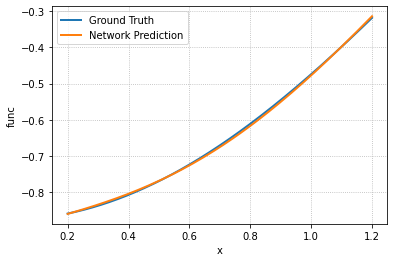

In [19]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, func_exact, label="Ground Truth",lw=2)
plt.plot(x_test, func_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("func")
plt.legend()

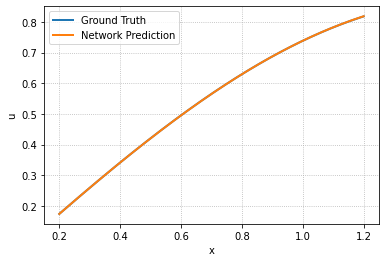

In [20]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [21]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  5.445719963859119e-06 %


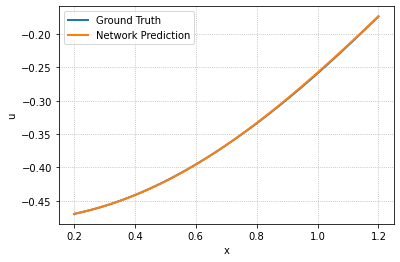

In [22]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [23]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.00025632950837461976 %


In [24]:
# D and B field

In [25]:
def exact_solution_B(x, t):
    return torch.sin(x)*torch.cos(t)

def exact_solution_D(x, t):
    return -2*torch.sin(t)*torch.cos(x)

In [26]:
b_test = exact_solution_B(x_test, t_test).reshape(-1,1)
d_test = exact_solution_D(x_test, t_test).reshape(-1,1)

b_test_pred = u_test_pred
d_test_pred = 2*p_test_pred

In [27]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((b_test_pred - b_test)**2)/torch.mean(b_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  5.445719963859119e-06 %


In [28]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((d_test_pred - d_test)**2)/torch.mean(d_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.00025632950837461976 %


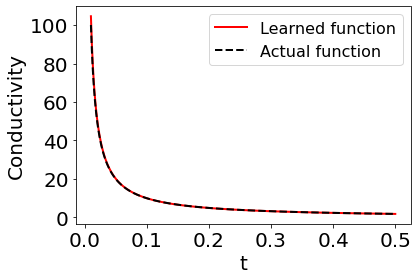

In [29]:
x_test = 0.5*torch.ones((1000,1))
t_test = torch.linspace(0.01, 0.5, 1000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)
func_test_pred = w_test_pred[:,2].reshape(-1,1)

func_exact  = torch.cos(x_test)*torch.cos(t_test)
func_exact = func_exact.reshape(-1,1)

con = func_test_pred/p_test_pred

plt.plot(t_test, con.detach(), 'r', linewidth=2)
plt.plot(t_test, np.cos(t_test)/np.sin(t_test), 'k--', linewidth=2)
plt.xlabel('t', fontsize = 20)
plt.ylabel('Conductivity', fontsize = 20)
plt.legend(['Learned function', 'Actual function'], prop={'size': 16})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("Results/oned/exp2/conductivity.png", dpi = 300, bbox_inches='tight')

In [30]:
# for ploting

In [31]:
model = my_network

x_test = torch.rand(100000) + 0.2 
x_test = x_test.reshape(-1,1)
t_test = 0.5*torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)

u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
f_test = torch.cos(x_test)*torch.cos(t_test)
f_test = f_test.reshape(-1,1)

u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)
p_pred = u_test_pred[:, 1].reshape(-1,1)
func_test_pred = u_test_pred[:, 2].reshape(-1,1)

relative_error_u = torch.abs(u_pred- u_test)
relative_error_p = torch.abs(p_pred- p_test)
relative_error_f = torch.abs(func_test_pred- f_test)

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_pred = u_pred.detach().numpy()
p_pred = p_pred.detach().numpy()
func_test_pred = func_test_pred.detach().numpy()

relative_error_u = relative_error_u.detach().numpy()
relative_error_p = relative_error_p.detach().numpy()
relative_error_f = relative_error_f.detach().numpy()

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)
func_test_pred = func_test_pred.reshape(-1,)

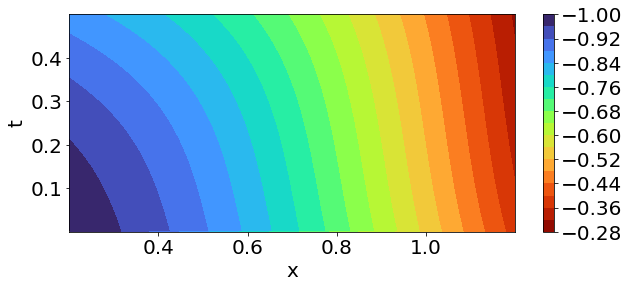

In [32]:
plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, func_test_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Results/oned/exp2/f_pred.png', dpi = 300, bbox_inches = "tight")

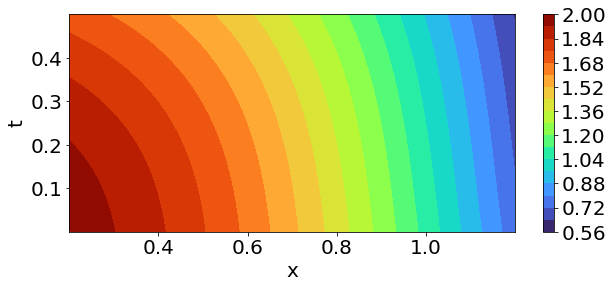

In [33]:
plt.rcParams['figure.figsize'] = [10, 4]
relative_error_f = relative_error_f.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_f, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Results/oned/exp2/f_error.png', dpi = 300, bbox_inches = "tight")

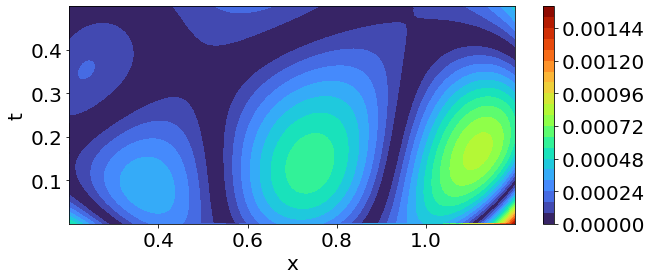

In [34]:
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error_u = relative_error_u.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_u, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp2/relative_error_H.png', dpi = 300, bbox_inches = "tight")

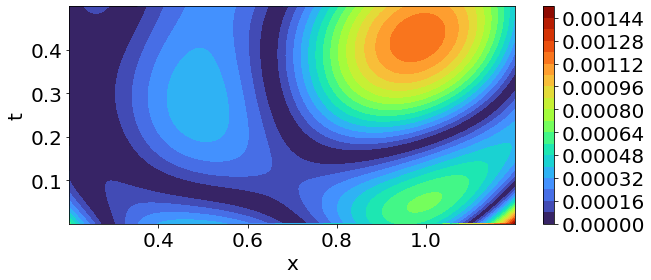

In [35]:
relative_error_p = relative_error_p.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_p, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp2/relative_error_E.png', dpi = 300, bbox_inches = "tight")

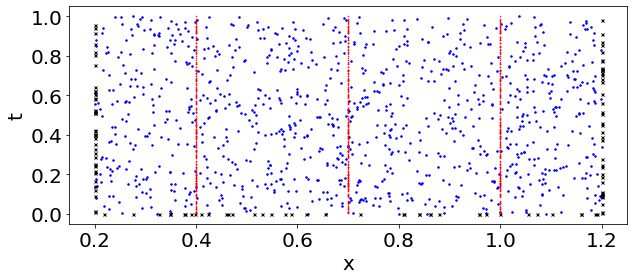

In [36]:
data_x1 = data_inp1[:, 0]
data_t1 = data_inp1[:, 1]

data_x2 = data_inp2[:, 0]
data_t2 = data_inp2[:, 1]

data_x3 = data_inp3[:, 0]
data_t3 = data_inp3[:, 1]

plt.plot(x_interior, t_interior, 'bo', ms=1.5)
plt.plot(x_init[::5], t_init[::5], "kx", ms=3)
plt.plot(xb_left[::5], tb_left[::5], "kx", ms=3)
plt.plot(xb_right[::5], tb_right[::5], "kx", ms=3)

plt.plot(data_x1[::2], data_t1[::2], 'ro', ms=0.5)
plt.plot(data_x2[::2], data_t2[::2], 'ro', ms=0.5)
plt.plot(data_x3[::2], data_t3[::2], 'ro', ms=0.5)

plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('Results/oned/exp2/data_pts.png', dpi = 300, bbox_inches = "tight")
plt.show()